In [1]:
!nvidia-smi

Fri May 28 08:43:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/Shareddrives/Silver Hallmarks/data/Chars74kDataset.zip' . 
!cp '/content/drive/Shareddrives/Silver Hallmarks/data/ClassificationYear.zip' . 
!unzip -q Chars74kDataset.zip
!unzip -q ClassificationYear.zip
!rm Chars74kDataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace newData_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:

!pip install -q -U albumentations

# Dataset


In [9]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import albumentations as albu
import albumentations.pytorch as albu_pytorch

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

In [53]:
class ClassificationDataset(Dataset):
    def __init__(self, dataset, data_dir, phase, image_shape, with_trans=True):
        self.phase = phase
        self.dir = os.path.join(data_dir, phase)
        # self.dir = data_dir
        self.dataset = dataset
        self.image_shape = image_shape
        self.with_trans = with_trans
        self.transforms = self.get_transforms(phase=self.phase, image_shape=image_shape)
        

    def __getitem__(self, index):
        row = self.dataset.iloc[index]

        target = row['target']
        # Convert target into [0, 0, 0, 1 ..., 0] format, instead of [0, 1, 2, 3 ...]
        target =  torch.zeros(26).float()
        target[row['target']] = 1
        image = cv2.imread(os.path.join(self.dir, row['ImageName']))

        if image is None:

            print(row)
            print(os.path.join(self.dir, row['ImageName']))
            print(row['ImageName'])
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = self.transforms(image=image)['image']
        
        return image / 255, torch.tensor(target, dtype=torch.long)
    

    def get_transforms(self, image_shape, phase, list_transforms=None):
        if not list_transforms:
            list_transforms = []

        if phase == 'train' and self.with_trans:
            list_transforms.extend(
                [
                    # albu.ShiftScaleRotate(
                    #     shift_limit=0.1, scale_limit=[-0.1, 0.1], rotate_limit=30,
                    #     always_apply=True, border_mode=cv2.BORDER_REFLECT
                    #     ),
                
                    # albu.HorizontalFlip(p=0.5),
                    # albu.VerticalFlip(p=0.5),
                    albu.IAAAdditiveGaussianNoise(p=0.2),
                 
                    albu.ElasticTransform(always_apply=False, p=0.8, alpha=1.0, sigma=5.0,
                                          alpha_affine=5.0, interpolation=0, border_mode=0, value=(90, 90, 90),
                                          mask_value=None, approximate=False),
                 
                    albu.GridDistortion(always_apply=False, p=0.8, num_steps=5,
                                   distort_limit=(-0.30, 0.3),
                                   interpolation=0, border_mode=0, value=(90, 90, 90), mask_value=None),
                    albu.OneOf(
                        [
                            albu.CLAHE(clip_limit=(1, 2.5), p=1),
                            albu.RandomBrightness(limit=[0, 0.25], p=1),
                            albu.RandomGamma(p=1),
                        ],
                        p=1,
                    ),

                    albu.OneOf(
                        [
                            albu.IAASharpen(p=0.5),
                            albu.Blur(blur_limit=3, p=1),
                            albu.MotionBlur(blur_limit=3, p=1),
                        ],
                        p=0.9,
                    ),

                    # albu.RandomContrast(p=1),

                ]
            )

        list_transforms.extend(
            [
                albu.Resize(image_shape[0], image_shape[1]),
                # albu.Normalize(mean=(69.0932, 69.3587, 68.9373), std=(48.4471, 48.4580, 48.,4263)),
                albu.pytorch.transforms.ToTensorV2()
            ]
        )

        list_transforms = albu.Compose(list_transforms)
        return list_transforms

    def __len__(self):
        return len(self.dataset)

def data_provider(dataframe_train, dataframe_val, image_shape, data_dir, batch_size=8, shuffle=True):
    dataloader = {
        'train': DataLoader(
            dataset=ClassificationDataset(dataframe_train, phase='train', data_dir=data_dir, image_shape=image_shape), 
            batch_size=batch_size,
            shuffle=shuffle
            ),
        'val': DataLoader(
            dataset=ClassificationDataset(dataframe_val, phase='val', data_dir=data_dir, image_shape=image_shape),
            batch_size=batch_size,
            shuffle=shuffle
            )
        }
    return dataloader

# Network

In [11]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs2')

# Trainer

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
import datetime


DIR_TO_SAVE_MODELS = '/content/drive/Shareddrives/Silver Hallmarks/models/'
DIR_TO_SAVE_LOG = '/content/drive/Shareddrives/Silver Hallmarks/log/'


class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device,
                 df_train, df_val, data_dir, image_shape, batch_size=8, best_score=None):

        self.device = device
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.batch_size = batch_size

        self.dataloaders = data_provider(
            df_train, df_val, batch_size=self.batch_size, data_dir=data_dir, image_shape=image_shape)
        
        self.losses = {phase: [] for phase in ['train', 'val']}

        self.metrics = {'AP': accuracy_score}
        self.metrics_values = {
            phase: {name: [] for name in self.metrics.keys()} for phase in ['train', 'val']
        }

        if best_score is not None:
            self.best_score = best_score
        else:
            self.best_score = np.array([-np.inf for _ in self.metrics.keys()])

        self.dir_to_save_models = os.path.join(
            DIR_TO_SAVE_MODELS, self.model.__class__.__name__, datetime.datetime.now().strftime('%Y-%m-%d'))
        
        self.dir_to_save_log = os.path.join(
            DIR_TO_SAVE_LOG, self.model.__class__.__name__, datetime.datetime.now().strftime('%Y-%m-%d'))

        if not os.path.exists(self.dir_to_save_models):
            os.makedirs(self.dir_to_save_models)

        if not os.path.exists(self.dir_to_save_log):
            os.makedirs(self.dir_to_save_log)


        

    def step(self, epoch, phase):
        epoch_loss = 0.0

        metrics = {name: [] for name in self.metrics.keys()}
        epoch_metric = {}

        if phase == 'train':
            self.model.train()
        else:
            self.model.eval()

        dataloader = self.dataloaders[phase]
        pbar = tqdm(dataloader, total=len(dataloader))

        self.optimizer.zero_grad()
        for i, (images, targets) in enumerate(dataloader):

            # images, targets = torch.tensor(images, dtype=torch.float), torch.tensor(targets, dtype=torch.long)
            images, targets = torch.tensor(images, dtype=torch.float), torch.tensor(targets, dtype=torch.float)

            images = images.to(self.device)
            targets = targets.to(self.device)


            with torch.set_grad_enabled(phase == 'train'):
               
                outputs1 = self.model(images)
                loss = self.criterion(outputs1, targets)
                
                if phase == "train":
                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                for metric in self.metrics.keys():
                    metrics[metric].append(
                        # self.metrics[metric](targets.cpu().detach().numpy(), outputs1.argmax(1).cpu().detach().numpy()))
                        self.metrics[metric](targets.argmax(1).cpu().detach().numpy(), outputs1.argmax(1).cpu().detach().numpy()))

                epoch_loss += loss.item()
                pbar.update(1)

            del images, targets, outputs1, loss
                
        pbar.close()
        epoch_loss = (epoch_loss) / len(dataloader)
        self.losses[phase].append(epoch_loss)
        
        for metric in self.metrics.keys():
            epoch_metric[metric] = np.mean(metrics[metric])
            self.metrics_values[phase][metric].append(epoch_metric[metric])
        
        torch.cuda.empty_cache()      
        return epoch_loss, epoch_metric

    def train(self, num_epochs):
        for epoch in tqdm(range(num_epochs)):

            loss, metric = self.step(epoch, 'train')
            train_loss, train_metric = loss, metric

            print('Epoch {} | train loss {} | metrics {}'.format(epoch, loss, metric))

            state = {
                'epoch': epoch,
                'state_dict': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(), 
                'scheduler': self.scheduler.state_dict()
                }

            loss , metric = self.step(epoch, 'val')
            val_loss, val_metric = loss, metric

            # Write into Tensorboard
            writer.add_scalars(
                'loss', 
                {'train': train_loss, 'val': val_loss},
                epoch
            )
            
            writer.add_scalars(
                'metric', 
                {'train': train_metric['AP'], 'val': val_metric['AP']},
                epoch
            )

            print('Epoch {} | val_loss {}  | metrics {}'.format(epoch, loss, metric))

            self.scheduler.step(loss)

            # Save best model
            scores = np.fromiter(metric.values(), dtype=np.float)
            if (scores[0] > self.best_score[0]).all():
                print('-' * 10 + 'New optimal model found and saved' + '-' * 10)
                state['best_metric'] = metric
                torch.save(state, "{}/model_epoch_{}_score_{:.4f}.pth".format(self.dir_to_save_models, epoch, scores[0]))
                self.best_score = scores

            losses_file = open("{}/loss_epoch_{}.json".format(self.dir_to_save_log, epoch), "w")
            json.dump(self.losses, losses_file)
            losses_file.close() 

            metrics_file = open("{}/metric_epoch_{}.json".format(self.dir_to_save_log, epoch), "w")
            json.dump(self.metrics_values, metrics_file)
            metrics_file.close()

        # saving last epoch
        print('-' * 10 + str(num_epochs) + 'passed' + '-' * 10)
        torch.save(state, "{}/model_epoch_{}_score_{:.4f}.pth".format(self.dir_to_save_models, num_epochs, scores[0]))


# Main

In [23]:
from sklearn.utils import class_weight

data = pd.read_csv('/content/newData_train.csv')
classes = list(range(26))
weights = class_weight.compute_class_weight('balanced', classes, data['target'])


# data = pd.read_csv('/content/ClassificationYear/letters_train.csv')
# data = data[data['LabelId'] != 26]
# data.rename(columns={'LabelId': 'target'}, inplace=True)

# weights = []
# for i in range(26):
#     weights.append(len(data) / (26 * len(data[data['target'] == i])))

In [17]:
import torchvision.models as models

# model = models.vgg11_bn(pretrained=True)
# model.classifier[6] =  torch.nn.Linear(in_features=4096, out_features=26, bias=True)

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=26, bias=True)

model.load_state_dict(torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/model_epoch_100_score_0.6816.pth')['state_dict'])


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


<All keys matched successfully>

In [70]:
import json
import torchvision.models as models


def ContinueTrain():

    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(in_features=512, out_features=26, bias=True)

    state = torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/ResNet/2021-05-16/model_epoch_81_score_0.6285.pth')
  
    model.load_state_dict(state['state_dict'])

    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=3, verbose=True)

    # optimizer.load_state_dict(state['optimizer'])
    # scheduler.load_state_dict(state['scheduler'])

    # # Optimizer to CUDA
    # for state_opt in optimizer.state.values():
    #     for k, v in state_opt.items():
    #         if isinstance(v, torch.Tensor):
    #             state_opt[k] = v.cuda()

    return model, criterion, optimizer, scheduler

def init_real_dataset():
    df_train = pd.read_csv('/content/ClassificationYear/letters_train.csv')
    df_train = df_train[df_train['LabelId'] != 26]
    df_train.rename(columns={'LabelId': 'target'}, inplace=True)

    df_val = pd.read_csv('/content/ClassificationYear/letters_val.csv')
    df_val = df_val[df_val['LabelId'] != 26]
    df_val.rename(columns={'LabelId': 'target'}, inplace=True)

    return df_train, df_val

def init_fake_dataset():
    df_train = pd.read_csv('/content/newData_train.csv')
    df_train['target'] = df_train['target'].astype(int)
    df_train['ImageName'] =  df_train['image_path'].map(lambda x: x.replace('\\', '/'))


    df_val = pd.read_csv('/content/newData_val.csv')
    df_val['target'] = df_val['target'].astype(int)
    df_val['ImageName'] =  df_val['image_path']

    return df_train, df_val

def fine_tunning():

    best_model = models.resnet18(pretrained=True)
    best_model.fc = torch.nn.Linear(in_features=512, out_features=26, bias=True)
    state = torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/ResNet/2021-05-28/model_epoch_110_score_0.9087.pth')
    best_model.load_state_dict(state['state_dict'])
    return best_model

if __name__ == '__main__':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Initialisation of the network

    # for param in model.parameters():
    #     param.requires_grad = True

    # Define optimizer and loss function
    model, criterion, optimizer, scheduler = ContinueTrain()
    model = fine_tunning()
    # criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    # criterion = torch.nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-5)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=3, verbose=True)

    df_train, df_val = init_real_dataset()

    model_train = Trainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        batch_size=212,
        df_train=df_train,
        df_val=df_val,
        # data_dir='/content/',
        data_dir = '/content/ClassificationYear/letters',
        image_shape=(70, 70)
    )

In [71]:
model_train.train(150) 


Epoch 0 | train loss 0.28449901938438416 | metrics {'AP': 0.28698583098387914}



Epoch 0 | val_loss 0.22746987640857697  | metrics {'AP': 0.2971698113207547}
----------New optimal model found and saved----------



Epoch 1 | train loss 0.28016966332991916 | metrics {'AP': 0.3000072290898576}



Epoch 1 | val_loss 0.23090369999408722  | metrics {'AP': 0.3160377358490566}
----------New optimal model found and saved----------



Epoch 2 | train loss 0.2758769541978836 | metrics {'AP': 0.30005241090146745}



Epoch 2 | val_loss 0.23247124254703522  | metrics {'AP': 0.32075471698113206}
----------New optimal model found and saved----------



Epoch 3 | train loss 0.2835855484008789 | metrics {'AP': 0.290916648593942}



Epoch 3 | val_loss 0.23684263229370117  | metrics {'AP': 0.32075471698113206}



Epoch 4 | train loss 0.2733880629142125 | metrics {'AP': 0.3133177907901395}



Epoch 4 | val_loss 0.23912431299686432  | metrics {'AP': 0.32075471698113206}
Epoch     5: reducing learning rate of group 0 to 4.5000e-03.



Epoch 5 | train loss 0.2726168632507324 | metrics {'AP': 0.3079140461215933}



Epoch 5 | val_loss 0.24144268035888672  | metrics {'AP': 0.32547169811320753}
----------New optimal model found and saved----------



Epoch 6 | train loss 0.2770313347379367 | metrics {'AP': 0.30083857442348005}



Epoch 6 | val_loss 0.24127361178398132  | metrics {'AP': 0.32547169811320753}



Epoch 7 | train loss 0.2692978059252103 | metrics {'AP': 0.3135165907612231}



Epoch 7 | val_loss 0.2409353107213974  | metrics {'AP': 0.32075471698113206}



Epoch 8 | train loss 0.2674166063467662 | metrics {'AP': 0.29278717559459266}



Epoch 8 | val_loss 0.24075102806091309  | metrics {'AP': 0.32547169811320753}
Epoch     9: reducing learning rate of group 0 to 4.0500e-03.



Epoch 9 | train loss 0.2695293078819911 | metrics {'AP': 0.290374466854623}



Epoch 9 | val_loss 0.2417861372232437  | metrics {'AP': 0.32075471698113206}



Epoch 10 | train loss 0.27173272768656415 | metrics {'AP': 0.3192637171980048}



Epoch 10 | val_loss 0.24254870414733887  | metrics {'AP': 0.330188679245283}
----------New optimal model found and saved----------



Epoch 11 | train loss 0.2834420179327329 | metrics {'AP': 0.2964197932480301}



Epoch 11 | val_loss 0.24253016710281372  | metrics {'AP': 0.32075471698113206}



Epoch 12 | train loss 0.272171492377917 | metrics {'AP': 0.3175919901684378}



Epoch 12 | val_loss 0.24168597161769867  | metrics {'AP': 0.32075471698113206}
Epoch    13: reducing learning rate of group 0 to 3.6450e-03.



Epoch 13 | train loss 0.2736352210243543 | metrics {'AP': 0.3039832285115304}



Epoch 13 | val_loss 0.24044786393642426  | metrics {'AP': 0.32075471698113206}



Epoch 14 | train loss 0.28145436694224674 | metrics {'AP': 0.2995644473360804}



Epoch 14 | val_loss 0.24037949740886688  | metrics {'AP': 0.32547169811320753}



Epoch 15 | train loss 0.27137333899736404 | metrics {'AP': 0.3055103737439456}



Epoch 15 | val_loss 0.24022741615772247  | metrics {'AP': 0.32547169811320753}



Epoch 16 | train loss 0.2663719331224759 | metrics {'AP': 0.3137605725439167}



Epoch 16 | val_loss 0.24002279341220856  | metrics {'AP': 0.32075471698113206}
Epoch    17: reducing learning rate of group 0 to 3.2805e-03.



Epoch 17 | train loss 0.28018808364868164 | metrics {'AP': 0.3093417913684667}



Epoch 17 | val_loss 0.23972372710704803  | metrics {'AP': 0.32547169811320753}



Epoch 18 | train loss 0.26815160115559894 | metrics {'AP': 0.31611906310995447}



Epoch 18 | val_loss 0.23750026524066925  | metrics {'AP': 0.32547169811320753}



Epoch 19 | train loss 0.27748197813828784 | metrics {'AP': 0.30329646497505963}



Epoch 19 | val_loss 0.23918676376342773  | metrics {'AP': 0.32547169811320753}



Epoch 20 | train loss 0.27434541781743366 | metrics {'AP': 0.316905226631967}



Epoch 20 | val_loss 0.23866909742355347  | metrics {'AP': 0.32547169811320753}
Epoch    21: reducing learning rate of group 0 to 2.9525e-03.



Epoch 21 | train loss 0.2779260203242302 | metrics {'AP': 0.3058989373237909}



Epoch 21 | val_loss 0.2405238002538681  | metrics {'AP': 0.32075471698113206}



Epoch 22 | train loss 0.28056147197882336 | metrics {'AP': 0.30442601026530763}



Epoch 22 | val_loss 0.24017798900604248  | metrics {'AP': 0.32547169811320753}



Epoch 23 | train loss 0.26635314027468365 | metrics {'AP': 0.2974499385527362}



Epoch 23 | val_loss 0.23850016295909882  | metrics {'AP': 0.330188679245283}



Epoch 24 | train loss 0.2699311897158623 | metrics {'AP': 0.31125750018072723}



Epoch 24 | val_loss 0.24148546159267426  | metrics {'AP': 0.32547169811320753}
Epoch    25: reducing learning rate of group 0 to 2.6572e-03.



Epoch 25 | train loss 0.2834643026192983 | metrics {'AP': 0.29470288440685316}



Epoch 25 | val_loss 0.2421696037054062  | metrics {'AP': 0.32547169811320753}



Epoch 26 | train loss 0.282431681950887 | metrics {'AP': 0.3242246801127738}



Epoch 26 | val_loss 0.24089008569717407  | metrics {'AP': 0.32547169811320753}



Epoch 27 | train loss 0.2692534426848094 | metrics {'AP': 0.3042814284681558}



Epoch 27 | val_loss 0.24070101976394653  | metrics {'AP': 0.330188679245283}



Epoch 28 | train loss 0.2852884382009506 | metrics {'AP': 0.2924889756379672}



Epoch 28 | val_loss 0.23939259350299835  | metrics {'AP': 0.330188679245283}
Epoch    29: reducing learning rate of group 0 to 2.3915e-03.



Epoch 29 | train loss 0.2875664681196213 | metrics {'AP': 0.3129292272102942}



Epoch 29 | val_loss 0.23927412927150726  | metrics {'AP': 0.330188679245283}



Epoch 30 | train loss 0.27213455239931744 | metrics {'AP': 0.2995644473360804}



Epoch 30 | val_loss 0.23748096823692322  | metrics {'AP': 0.330188679245283}



Epoch 31 | train loss 0.2681438500682513 | metrics {'AP': 0.3138599725294586}



Epoch 31 | val_loss 0.24057409167289734  | metrics {'AP': 0.32547169811320753}



Epoch 32 | train loss 0.28090353310108185 | metrics {'AP': 0.3067393190197354}



Epoch 32 | val_loss 0.24054738879203796  | metrics {'AP': 0.32547169811320753}
Epoch    33: reducing learning rate of group 0 to 2.1523e-03.



Epoch 33 | train loss 0.26167298356692 | metrics {'AP': 0.3288874430709174}



Epoch 33 | val_loss 0.23895223438739777  | metrics {'AP': 0.32547169811320753}



Epoch 34 | train loss 0.2760285387436549 | metrics {'AP': 0.31779079013952144}



Epoch 34 | val_loss 0.24136707186698914  | metrics {'AP': 0.32547169811320753}



Epoch 35 | train loss 0.26676370948553085 | metrics {'AP': 0.3176913901539796}



Epoch 35 | val_loss 0.2405954897403717  | metrics {'AP': 0.32075471698113206}



Epoch 36 | train loss 0.2802292803923289 | metrics {'AP': 0.3138599725294586}



Epoch 36 | val_loss 0.24022215604782104  | metrics {'AP': 0.32547169811320753}
Epoch    37: reducing learning rate of group 0 to 1.9371e-03.



Epoch 37 | train loss 0.2736911177635193 | metrics {'AP': 0.3245680618810092}



Epoch 37 | val_loss 0.23934054374694824  | metrics {'AP': 0.330188679245283}



Epoch 38 | train loss 0.2822437758247058 | metrics {'AP': 0.2956788115376274}



Epoch 38 | val_loss 0.23901882767677307  | metrics {'AP': 0.32547169811320753}



Epoch 39 | train loss 0.2745933433373769 | metrics {'AP': 0.3115466637750307}



Epoch 39 | val_loss 0.240279421210289  | metrics {'AP': 0.32547169811320753}



Epoch 40 | train loss 0.2750217467546463 | metrics {'AP': 0.2940613026819923}



Epoch 40 | val_loss 0.23796673119068146  | metrics {'AP': 0.330188679245283}
Epoch    41: reducing learning rate of group 0 to 1.7434e-03.



Epoch 41 | train loss 0.27609074612458545 | metrics {'AP': 0.30757066435335795}



Epoch 41 | val_loss 0.23961955308914185  | metrics {'AP': 0.32075471698113206}



Epoch 42 | train loss 0.2685152664780617 | metrics {'AP': 0.30698330080242897}



Epoch 42 | val_loss 0.24091224372386932  | metrics {'AP': 0.32547169811320753}



Epoch 43 | train loss 0.2763710618019104 | metrics {'AP': 0.3084562278609123}



Epoch 43 | val_loss 0.2412547469139099  | metrics {'AP': 0.32075471698113206}



Epoch 44 | train loss 0.2651991049448649 | metrics {'AP': 0.3190197354153112}



Epoch 44 | val_loss 0.24059894680976868  | metrics {'AP': 0.32547169811320753}
Epoch    45: reducing learning rate of group 0 to 1.5691e-03.



Epoch 45 | train loss 0.28017233312129974 | metrics {'AP': 0.3060977372948746}



Epoch 45 | val_loss 0.2406383901834488  | metrics {'AP': 0.32547169811320753}



Epoch 46 | train loss 0.28427688280741376 | metrics {'AP': 0.3028085014096725}



Epoch 46 | val_loss 0.24207641184329987  | metrics {'AP': 0.3160377358490566}



Epoch 47 | train loss 0.2721379945675532 | metrics {'AP': 0.31071531844140826}



Epoch 47 | val_loss 0.24150021374225616  | metrics {'AP': 0.32547169811320753}



Epoch 48 | train loss 0.279993511736393 | metrics {'AP': 0.30246511964143713}



Epoch 48 | val_loss 0.23999270796775818  | metrics {'AP': 0.330188679245283}
Epoch    49: reducing learning rate of group 0 to 1.4121e-03.



Epoch 49 | train loss 0.28162655731042224 | metrics {'AP': 0.29740475674112626}



Epoch 49 | val_loss 0.2397564947605133  | metrics {'AP': 0.330188679245283}



Epoch 50 | train loss 0.2702265481154124 | metrics {'AP': 0.31430275428323573}



Epoch 50 | val_loss 0.24040459096431732  | metrics {'AP': 0.32547169811320753}



Epoch 51 | train loss 0.28505922357241315 | metrics {'AP': 0.3092875731945348}



Epoch 51 | val_loss 0.24047228693962097  | metrics {'AP': 0.330188679245283}



Epoch 52 | train loss 0.2802671591440837 | metrics {'AP': 0.3052663919612521}



Epoch 52 | val_loss 0.24129685759544373  | metrics {'AP': 0.32547169811320753}
Epoch    53: reducing learning rate of group 0 to 1.2709e-03.



Epoch 53 | train loss 0.2718641683459282 | metrics {'AP': 0.2806965228077785}



Epoch 53 | val_loss 0.2410052865743637  | metrics {'AP': 0.330188679245283}



Epoch 54 | train loss 0.2731129949291547 | metrics {'AP': 0.3218210077351262}



Epoch 54 | val_loss 0.24038353562355042  | metrics {'AP': 0.32547169811320753}



Epoch 55 | train loss 0.2701234569152196 | metrics {'AP': 0.30992915491939566}



Epoch 55 | val_loss 0.23943239450454712  | metrics {'AP': 0.330188679245283}



Epoch 56 | train loss 0.28316770245631534 | metrics {'AP': 0.3015253379599508}



Epoch 56 | val_loss 0.2403525412082672  | metrics {'AP': 0.32547169811320753}
Epoch    57: reducing learning rate of group 0 to 1.1438e-03.



Epoch 57 | train loss 0.2772096147139867 | metrics {'AP': 0.29426010265307595}



Epoch 57 | val_loss 0.24203214049339294  | metrics {'AP': 0.32075471698113206}



Epoch 58 | train loss 0.2791660229365031 | metrics {'AP': 0.30123617436564737}



Epoch 58 | val_loss 0.24076031148433685  | metrics {'AP': 0.32075471698113206}



Epoch 59 | train loss 0.280601608256499 | metrics {'AP': 0.30658570086026166}



Epoch 59 | val_loss 0.2402827888727188  | metrics {'AP': 0.330188679245283}



Epoch 60 | train loss 0.27520887553691864 | metrics {'AP': 0.30349526494614326}



Epoch 60 | val_loss 0.24188292026519775  | metrics {'AP': 0.32075471698113206}
Epoch    61: reducing learning rate of group 0 to 1.0295e-03.



Epoch 61 | train loss 0.27108927567799884 | metrics {'AP': 0.316905226631967}



Epoch 61 | val_loss 0.24276015162467957  | metrics {'AP': 0.32075471698113206}



Epoch 62 | train loss 0.26836950580279034 | metrics {'AP': 0.3154322995734837}



Epoch 62 | val_loss 0.24067069590091705  | metrics {'AP': 0.32547169811320753}



Epoch 63 | train loss 0.2835756043593089 | metrics {'AP': 0.29823610207474877}



Epoch 63 | val_loss 0.24024248123168945  | metrics {'AP': 0.32547169811320753}



Epoch 64 | train loss 0.2790038237969081 | metrics {'AP': 0.3027091014241307}



Epoch 64 | val_loss 0.23904773592948914  | metrics {'AP': 0.330188679245283}
Epoch    65: reducing learning rate of group 0 to 9.2651e-04.



Epoch 65 | train loss 0.281823734442393 | metrics {'AP': 0.2944046844502277}



Epoch 65 | val_loss 0.23961013555526733  | metrics {'AP': 0.330188679245283}



Epoch 66 | train loss 0.2826850612958272 | metrics {'AP': 0.2899859032747777}



Epoch 66 | val_loss 0.24028898775577545  | metrics {'AP': 0.330188679245283}



Epoch 67 | train loss 0.2739976445833842 | metrics {'AP': 0.3021669196848117}



Epoch 67 | val_loss 0.23945744335651398  | metrics {'AP': 0.32547169811320753}



Epoch 68 | train loss 0.2796206797162692 | metrics {'AP': 0.3018235379165763}



Epoch 68 | val_loss 0.23847022652626038  | metrics {'AP': 0.32547169811320753}
Epoch    69: reducing learning rate of group 0 to 8.3386e-04.



Epoch 69 | train loss 0.28481412927309674 | metrics {'AP': 0.3018687197281862}



Epoch 69 | val_loss 0.2402256429195404  | metrics {'AP': 0.32075471698113206}



Epoch 70 | train loss 0.2691539799173673 | metrics {'AP': 0.304182028482614}



Epoch 70 | val_loss 0.23950859904289246  | metrics {'AP': 0.32547169811320753}



Epoch 71 | train loss 0.2777709538737933 | metrics {'AP': 0.31793537193667315}



Epoch 71 | val_loss 0.23991608619689941  | metrics {'AP': 0.32075471698113206}



Epoch 72 | train loss 0.27811088661352795 | metrics {'AP': 0.2974047567411263}



Epoch 72 | val_loss 0.2403866946697235  | metrics {'AP': 0.32547169811320753}
Epoch    73: reducing learning rate of group 0 to 7.5047e-04.



Epoch 73 | train loss 0.2822851836681366 | metrics {'AP': 0.3157304995301091}



Epoch 73 | val_loss 0.23985891044139862  | metrics {'AP': 0.330188679245283}



Epoch 74 | train loss 0.27156397700309753 | metrics {'AP': 0.31174546374611434}



Epoch 74 | val_loss 0.2406589686870575  | metrics {'AP': 0.32547169811320753}



Epoch 75 | train loss 0.28227206071217853 | metrics {'AP': 0.29283235740620256}



Epoch 75 | val_loss 0.23905690014362335  | metrics {'AP': 0.32547169811320753}



Epoch 76 | train loss 0.27008503675460815 | metrics {'AP': 0.30103737439456374}



Epoch 76 | val_loss 0.2389761060476303  | metrics {'AP': 0.32547169811320753}
Epoch    77: reducing learning rate of group 0 to 6.7543e-04.



Epoch 77 | train loss 0.2735153262813886 | metrics {'AP': 0.3074712643678161}



Epoch 77 | val_loss 0.24152399599552155  | metrics {'AP': 0.32075471698113206}



Epoch 78 | train loss 0.2771381090084712 | metrics {'AP': 0.301968119713728}



Epoch 78 | val_loss 0.24070803821086884  | metrics {'AP': 0.330188679245283}



Epoch 79 | train loss 0.2715548649430275 | metrics {'AP': 0.30344104677221134}



Epoch 79 | val_loss 0.24265864491462708  | metrics {'AP': 0.32075471698113206}



Epoch 80 | train loss 0.2789171536763509 | metrics {'AP': 0.2993656473649967}



Epoch 80 | val_loss 0.24124369025230408  | metrics {'AP': 0.32547169811320753}
Epoch    81: reducing learning rate of group 0 to 6.0788e-04.



Epoch 81 | train loss 0.28238625327746075 | metrics {'AP': 0.28674184920118556}



Epoch 81 | val_loss 0.24194058775901794  | metrics {'AP': 0.32547169811320753}



Epoch 82 | train loss 0.27783096333344776 | metrics {'AP': 0.303639846743295}



Epoch 82 | val_loss 0.2429812252521515  | metrics {'AP': 0.32075471698113206}



Epoch 83 | train loss 0.26657986640930176 | metrics {'AP': 0.3002512108725511}



Epoch 83 | val_loss 0.24270230531692505  | metrics {'AP': 0.32075471698113206}



Epoch 84 | train loss 0.27250496794780094 | metrics {'AP': 0.30599833730933274}



Epoch 84 | val_loss 0.2414899319410324  | metrics {'AP': 0.32075471698113206}
Epoch    85: reducing learning rate of group 0 to 5.4709e-04.



Epoch 85 | train loss 0.27311091125011444 | metrics {'AP': 0.30069399262632834}



Epoch 85 | val_loss 0.24107159674167633  | metrics {'AP': 0.32547169811320753}



Epoch 86 | train loss 0.2649423728386561 | metrics {'AP': 0.3001518108870093}



Epoch 86 | val_loss 0.23981647193431854  | metrics {'AP': 0.32547169811320753}



Epoch 87 | train loss 0.27693914870421094 | metrics {'AP': 0.2857568857080894}



Epoch 87 | val_loss 0.2398175150156021  | metrics {'AP': 0.32547169811320753}



Epoch 88 | train loss 0.27332234879334766 | metrics {'AP': 0.2994650473505386}



Epoch 88 | val_loss 0.24127914011478424  | metrics {'AP': 0.32547169811320753}
Epoch    89: reducing learning rate of group 0 to 4.9239e-04.



Epoch 89 | train loss 0.27425805230935413 | metrics {'AP': 0.322995734836984}



Epoch 89 | val_loss 0.24269157648086548  | metrics {'AP': 0.3160377358490566}



Epoch 90 | train loss 0.2724796136220296 | metrics {'AP': 0.3103719366731728}



Epoch 90 | val_loss 0.24231307208538055  | metrics {'AP': 0.32075471698113206}



Epoch 91 | train loss 0.2794494132200877 | metrics {'AP': 0.28472674040338325}



Epoch 91 | val_loss 0.23923809826374054  | metrics {'AP': 0.330188679245283}



Epoch 92 | train loss 0.26981766770283383 | metrics {'AP': 0.3084562278609123}



Epoch 92 | val_loss 0.2393140196800232  | metrics {'AP': 0.32075471698113206}
Epoch    93: reducing learning rate of group 0 to 4.4315e-04.



Epoch 93 | train loss 0.27948706845442456 | metrics {'AP': 0.28944372153545866}



Epoch 93 | val_loss 0.23915128409862518  | metrics {'AP': 0.32547169811320753}



Epoch 94 | train loss 0.27117466429869336 | metrics {'AP': 0.2999078291043158}



Epoch 94 | val_loss 0.23954111337661743  | metrics {'AP': 0.32075471698113206}



Epoch 95 | train loss 0.2773857116699219 | metrics {'AP': 0.31553169955902555}



Epoch 95 | val_loss 0.24055486917495728  | metrics {'AP': 0.32075471698113206}



Epoch 96 | train loss 0.2729029779632886 | metrics {'AP': 0.3054109737584038}



Epoch 96 | val_loss 0.24025729298591614  | metrics {'AP': 0.32075471698113206}
Epoch    97: reducing learning rate of group 0 to 3.9883e-04.



Epoch 97 | train loss 0.283126840988795 | metrics {'AP': 0.30246511964143713}



Epoch 97 | val_loss 0.24133624136447906  | metrics {'AP': 0.32075471698113206}



Epoch 98 | train loss 0.27012090384960175 | metrics {'AP': 0.3050675919901685}



Epoch 98 | val_loss 0.23991799354553223  | metrics {'AP': 0.32547169811320753}



Epoch 99 | train loss 0.27543527881304425 | metrics {'AP': 0.3067845008313453}



Epoch 99 | val_loss 0.24250410497188568  | metrics {'AP': 0.32075471698113206}



Epoch 100 | train loss 0.2743186205625534 | metrics {'AP': 0.3015253379599508}



Epoch 100 | val_loss 0.24154144525527954  | metrics {'AP': 0.330188679245283}
Epoch   101: reducing learning rate of group 0 to 3.5895e-04.



Epoch 101 | train loss 0.2699622909228007 | metrics {'AP': 0.30767006433889976}



Epoch 101 | val_loss 0.24072566628456116  | metrics {'AP': 0.32547169811320753}



Epoch 102 | train loss 0.28171273569266003 | metrics {'AP': 0.30025121087255113}



Epoch 102 | val_loss 0.24173744022846222  | metrics {'AP': 0.32075471698113206}



Epoch 103 | train loss 0.2702933152516683 | metrics {'AP': 0.30737186438227426}



Epoch 103 | val_loss 0.24246898293495178  | metrics {'AP': 0.32547169811320753}



Epoch 104 | train loss 0.2720606078704198 | metrics {'AP': 0.311944263717198}



Epoch 104 | val_loss 0.2391434907913208  | metrics {'AP': 0.330188679245283}
Epoch   105: reducing learning rate of group 0 to 3.2305e-04.



Epoch 105 | train loss 0.27069174001614255 | metrics {'AP': 0.32398069833008025}



Epoch 105 | val_loss 0.2378513067960739  | metrics {'AP': 0.32547169811320753}



Epoch 106 | train loss 0.2751813034216563 | metrics {'AP': 0.30865502783199594}



Epoch 106 | val_loss 0.23884961009025574  | metrics {'AP': 0.32547169811320753}



Epoch 107 | train loss 0.27376924206813175 | metrics {'AP': 0.31513409961685823}



Epoch 107 | val_loss 0.24079082906246185  | metrics {'AP': 0.32075471698113206}



Epoch 108 | train loss 0.2742809255917867 | metrics {'AP': 0.3167606448348153}



Epoch 108 | val_loss 0.2413036823272705  | metrics {'AP': 0.32075471698113206}
Epoch   109: reducing learning rate of group 0 to 2.9075e-04.



Epoch 109 | train loss 0.283179335296154 | metrics {'AP': 0.30059459264078653}



Epoch 109 | val_loss 0.24039839208126068  | metrics {'AP': 0.32075471698113206}



Epoch 110 | train loss 0.2733758787314097 | metrics {'AP': 0.30329646497505963}



Epoch 110 | val_loss 0.24006012082099915  | metrics {'AP': 0.32075471698113206}



Epoch 111 | train loss 0.28449322283267975 | metrics {'AP': 0.3116008819489626}



Epoch 111 | val_loss 0.24289436638355255  | metrics {'AP': 0.32075471698113206}



Epoch 112 | train loss 0.2749175528685252 | metrics {'AP': 0.29238957565242535}



Epoch 112 | val_loss 0.24158811569213867  | metrics {'AP': 0.32547169811320753}
Epoch   113: reducing learning rate of group 0 to 2.6167e-04.



Epoch 113 | train loss 0.27907172838846844 | metrics {'AP': 0.3028536832212825}



Epoch 113 | val_loss 0.2409130185842514  | metrics {'AP': 0.330188679245283}



Epoch 114 | train loss 0.2706373209754626 | metrics {'AP': 0.30737186438227426}



Epoch 114 | val_loss 0.242173433303833  | metrics {'AP': 0.330188679245283}



Epoch 115 | train loss 0.27773039788007736 | metrics {'AP': 0.29435046627629585}



Epoch 115 | val_loss 0.24066826701164246  | metrics {'AP': 0.32547169811320753}



Epoch 116 | train loss 0.26499971250693005 | metrics {'AP': 0.3111581001951854}



Epoch 116 | val_loss 0.24004366993904114  | metrics {'AP': 0.32547169811320753}
Epoch   117: reducing learning rate of group 0 to 2.3551e-04.



Epoch 117 | train loss 0.275894155104955 | metrics {'AP': 0.2958324296971011}



Epoch 117 | val_loss 0.23995399475097656  | metrics {'AP': 0.32075471698113206}



Epoch 118 | train loss 0.26545849442481995 | metrics {'AP': 0.3293844429986265}



Epoch 118 | val_loss 0.24033403396606445  | metrics {'AP': 0.32075471698113206}



Epoch 119 | train loss 0.2744259312748909 | metrics {'AP': 0.2944046844502277}



Epoch 119 | val_loss 0.2394229769706726  | metrics {'AP': 0.32547169811320753}



Epoch 120 | train loss 0.2869713480273883 | metrics {'AP': 0.28315441335935804}



Epoch 120 | val_loss 0.23985111713409424  | metrics {'AP': 0.32547169811320753}
Epoch   121: reducing learning rate of group 0 to 2.1196e-04.



Epoch 121 | train loss 0.2732313598195712 | metrics {'AP': 0.3134171907756813}



Epoch 121 | val_loss 0.24041646718978882  | metrics {'AP': 0.32547169811320753}



Epoch 122 | train loss 0.26296959072351456 | metrics {'AP': 0.3176913901539796}



Epoch 122 | val_loss 0.23941262066364288  | metrics {'AP': 0.330188679245283}



Epoch 123 | train loss 0.2815822015206019 | metrics {'AP': 0.29799212029205524}



Epoch 123 | val_loss 0.24122460186481476  | metrics {'AP': 0.32547169811320753}



Epoch 124 | train loss 0.27293626964092255 | metrics {'AP': 0.31577568134171907}



Epoch 124 | val_loss 0.24050253629684448  | metrics {'AP': 0.32075471698113206}
Epoch   125: reducing learning rate of group 0 to 1.9076e-04.



Epoch 125 | train loss 0.274082213640213 | metrics {'AP': 0.3013807561627991}



Epoch 125 | val_loss 0.2413916438817978  | metrics {'AP': 0.32075471698113206}



Epoch 126 | train loss 0.28368213027715683 | metrics {'AP': 0.2999078291043158}



Epoch 126 | val_loss 0.23999524116516113  | metrics {'AP': 0.330188679245283}



Epoch 127 | train loss 0.27692852914333344 | metrics {'AP': 0.29224499385527364}



Epoch 127 | val_loss 0.24129177629947662  | metrics {'AP': 0.32547169811320753}



Epoch 128 | train loss 0.2848011205593745 | metrics {'AP': 0.29332935733391163}



Epoch 128 | val_loss 0.24275675415992737  | metrics {'AP': 0.32075471698113206}
Epoch   129: reducing learning rate of group 0 to 1.7168e-04.



Epoch 129 | train loss 0.2727217475573222 | metrics {'AP': 0.28698583098387914}



Epoch 129 | val_loss 0.24219441413879395  | metrics {'AP': 0.32075471698113206}



Epoch 130 | train loss 0.27769974370797473 | metrics {'AP': 0.3054109737584038}



Epoch 130 | val_loss 0.24124597012996674  | metrics {'AP': 0.32075471698113206}



Epoch 131 | train loss 0.2827803393205007 | metrics {'AP': 0.31184486373165615}



Epoch 131 | val_loss 0.24093811213970184  | metrics {'AP': 0.32075471698113206}



Epoch 132 | train loss 0.2804027671615283 | metrics {'AP': 0.28374177691028696}



Epoch 132 | val_loss 0.2408723682165146  | metrics {'AP': 0.32547169811320753}
Epoch   133: reducing learning rate of group 0 to 1.5452e-04.



Epoch 133 | train loss 0.2746986821293831 | metrics {'AP': 0.30035061085809295}



Epoch 133 | val_loss 0.2412743866443634  | metrics {'AP': 0.32075471698113206}



Epoch 134 | train loss 0.27122490604718524 | metrics {'AP': 0.3097845731222439}



Epoch 134 | val_loss 0.2412271946668625  | metrics {'AP': 0.32547169811320753}



Epoch 135 | train loss 0.27641218652327854 | metrics {'AP': 0.3048687920190848}



Epoch 135 | val_loss 0.23983663320541382  | metrics {'AP': 0.330188679245283}



Epoch 136 | train loss 0.27423377831776935 | metrics {'AP': 0.30305248319236605}



Epoch 136 | val_loss 0.2392776757478714  | metrics {'AP': 0.32547169811320753}
Epoch   137: reducing learning rate of group 0 to 1.3906e-04.



Epoch 137 | train loss 0.2770894045631091 | metrics {'AP': 0.29686257500180724}



Epoch 137 | val_loss 0.23801060020923615  | metrics {'AP': 0.32547169811320753}



Epoch 138 | train loss 0.27398351579904556 | metrics {'AP': 0.3061971372804164}



Epoch 138 | val_loss 0.23996558785438538  | metrics {'AP': 0.32547169811320753}



Epoch 139 | train loss 0.27769150336583454 | metrics {'AP': 0.2777958505024218}



Epoch 139 | val_loss 0.23953093588352203  | metrics {'AP': 0.32547169811320753}



Epoch 140 | train loss 0.2723285953203837 | metrics {'AP': 0.3136611725583749}



Epoch 140 | val_loss 0.24058127403259277  | metrics {'AP': 0.32547169811320753}
Epoch   141: reducing learning rate of group 0 to 1.2516e-04.



Epoch 141 | train loss 0.2805187677343686 | metrics {'AP': 0.32555302537410535}



Epoch 141 | val_loss 0.2396012395620346  | metrics {'AP': 0.32547169811320753}



Epoch 142 | train loss 0.2744511514902115 | metrics {'AP': 0.3066851008458035}



Epoch 142 | val_loss 0.24003231525421143  | metrics {'AP': 0.330188679245283}



Epoch 143 | train loss 0.2738867277900378 | metrics {'AP': 0.301968119713728}



Epoch 143 | val_loss 0.24073883891105652  | metrics {'AP': 0.32075471698113206}



Epoch 144 | train loss 0.2783059626817703 | metrics {'AP': 0.29720595677004263}



Epoch 144 | val_loss 0.24199236929416656  | metrics {'AP': 0.32075471698113206}
Epoch   145: reducing learning rate of group 0 to 1.1264e-04.



Epoch 145 | train loss 0.27448145548502606 | metrics {'AP': 0.2911154485650257}



Epoch 145 | val_loss 0.2406110167503357  | metrics {'AP': 0.32547169811320753}



Epoch 146 | train loss 0.27317312856515247 | metrics {'AP': 0.311944263717198}



Epoch 146 | val_loss 0.2409394234418869  | metrics {'AP': 0.32547169811320753}



Epoch 147 | train loss 0.26738809049129486 | metrics {'AP': 0.30599833730933274}



Epoch 147 | val_loss 0.23953326046466827  | metrics {'AP': 0.330188679245283}



Epoch 148 | train loss 0.282404529551665 | metrics {'AP': 0.3140045543266103}



Epoch 148 | val_loss 0.2402687668800354  | metrics {'AP': 0.330188679245283}
Epoch   149: reducing learning rate of group 0 to 1.0138e-04.



Epoch 149 | train loss 0.2764955411354701 | metrics {'AP': 0.29297693920335427}



Epoch 149 | val_loss 0.2403179258108139  | metrics {'AP': 0.32547169811320753}

----------150passed----------


In [ ]:
model_train.train(110)

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir runs2

In [ ]:
best_model = models.resnet18(pretrained=True)
best_model.fc = torch.nn.Linear(in_features=512, out_features=26, bias=True)
state = torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/ResNet/2021-05-28/model_epoch_110_score_0.9087.pth')
best_model.load_state_dict(state['state_dict'])


best_model.to(device);
best_model.eval();

In [ ]:
aplhabet = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
            'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

In [ ]:
import torch
import random

df_val = pd.read_csv('/content/ClassificationYear/letters_val.csv')
df_val = df_val[df_val['LabelId'] != 26]
df_val.rename(columns={'LabelId': 'target'}, inplace=True)


dataset = ClassificationDataset(df_val, 
                                data_dir='/content/ClassificationYear/letters', phase='val', image_shape=(70, 70), 
                                with_trans=True)
res = 0
y_true = []
y_pred = []
loss = {}
criterion = torch.nn.BCEWithLogitsLoss()

for i in tqdm(range(len(dataset))):
    
    image,  label = dataset.__getitem__(i)

    output = best_model(image.unsqueeze(0).to(device))
    # print(label.reshape(1, 26))
    # print(output)
    loss[i] = criterion(output, label.reshape(1, 26).float().to(device)).detach().cpu().item()
    
    y_true.append(label.argmax().item())
    y_pred.append(output.argmax().item())

    


In [ ]:
import collections
od = collections.OrderedDict(sorted(loss.items(), key=lambda x: x[1], reverse=True))
od.items()

odict_items([(185, 10.360736846923828), (184, 9.582626342773438), (13, 7.544942855834961), (162, 7.438226222991943), (105, 7.284750938415527), (95, 7.256282329559326), (11, 7.091603755950928), (35, 7.052183628082275), (189, 6.566571235656738), (169, 6.442612171173096), (85, 6.435290813446045), (149, 6.202220439910889), (43, 5.9807610511779785), (154, 5.459560394287109), (181, 5.248935222625732), (62, 5.234493255615234), (142, 5.030874252319336), (25, 4.871460914611816), (183, 4.854393005371094), (81, 4.713624000549316), (65, 4.609813690185547), (165, 4.46057653427124), (99, 4.434067726135254), (132, 4.393743991851807), (123, 4.329042911529541), (138, 4.317781448364258), (14, 4.163213729858398), (75, 4.100707054138184), (57, 4.064799785614014), (209, 4.046988010406494), (171, 4.030388832092285), (33, 4.020673751831055), (4, 3.902878761291504), (121, 3.890261650085449), (177, 3.6238136291503906), (152, 3.4789557456970215), (196, 3.3685178756713867), (60, 3.3601698875427246), (26, 3.32488

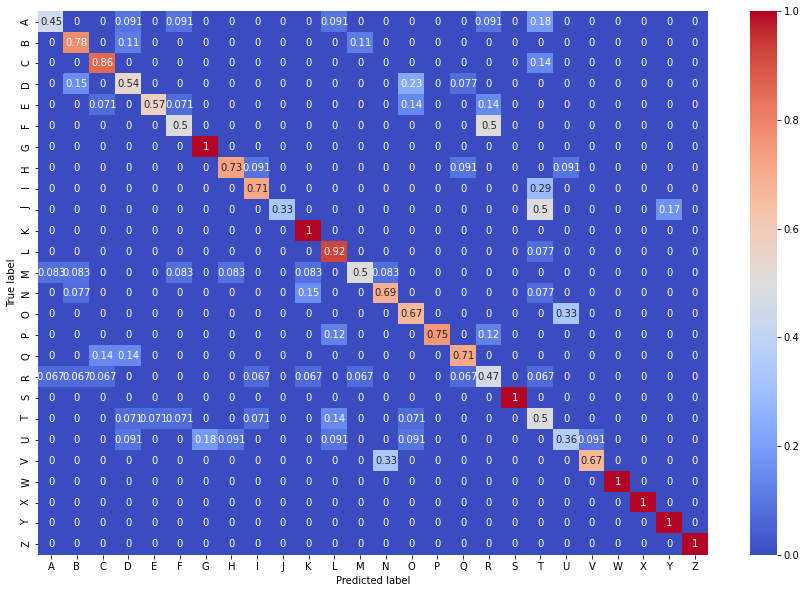

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_true, y_pred, normalize='true'),
    annot=True,
    cmap='coolwarm',
    xticklabels=aplhabet,
    yticklabels=aplhabet
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks();


$$\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$$

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.6556603773584906

$$\texttt{balanced-accuracy} = \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right )$$

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_true, y_pred)

0.7199059487521027

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
report = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('report_val.csv')

              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.58      0.78      0.67         9
           2       0.67      0.86      0.75         7
           3       0.58      0.54      0.56        13
           4       0.89      0.57      0.70        14
           5       0.43      0.50      0.46         6
           6       0.75      1.00      0.86         6
           7       0.80      0.73      0.76        11
           8       0.62      0.71      0.67         7
           9       1.00      0.33      0.50         6
          10       0.50      1.00      0.67         4
          11       0.71      0.92      0.80        13
          12       0.75      0.50      0.60        12
          13       0.82      0.69      0.75        13
          14       0.36      0.67      0.47         6
          15       1.00      0.75      0.86         8
          16       0.62      0.71      0.67         7
          17       0.50    

In [ ]:
import torch
import random

df_val = pd.read_csv('/content/ClassificationYear/letters_train.csv')
df_val = df_val[df_val['LabelId'] != 26]
df_val.rename(columns={'LabelId': 'target'}, inplace=True)


dataset = ClassificationDataset(df_val, data_dir='/content/ClassificationYear/letters', phase='train', image_shape=(70, 70))
res = 0
y_true = []
y_pred = []
for i, j in od.items():
    print
    image,  label = dataset.__getitem__(i)
    
    output = model(image.unsqueeze(0).to('cuda')).detach().cpu().numpy().ravel()
    image = image.permute(1, 2, 0)


    plt.imshow(image)
    plt.show()

    print(label.item(), output.argmax().item())
    top3_index = output.argsort()[-3:][::-1]
    print(aplhabet[top3_index], top3_index,  aplhabet[label.item()])

# show data


In [ ]:
import torch
import random
aplhabet = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
            'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])


df_val = pd.read_csv('/content/ClassificationYear/letters_val.csv')
df_val = df_val[df_val['LabelId'] != 26]
df_val.rename(columns={'LabelId': 'target'}, inplace=True)


dataset = ClassificationDataset(df_val, data_dir='/content/ClassificationYear/letters', phase='val', image_shape=(70, 70))
keys = od.keys
for i, j in od.items():
    print(i, j)
    image,  label = dataset.__getitem__(i)

    
    # output = best_model(image.unsqueeze(0).to(device))
    print(aplhabet[label.argmax()])
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    # plt.title(aplhabet[label.item()] + str(aplhabet[output.argmax()]))
    plt.show()
    # print(aplhabet[label.item()], output.detach().cpu())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/Shareddrives/Silver Hallmarks/data/test.zip' . 
!unzip -o -q test.zip
!rm test.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
best_model1 = models.resnet18(pretrained=True)
best_model1.fc = torch.nn.Linear(in_features=512, out_features=26, bias=True)

best_model2 = models.resnet18(pretrained=True)
best_model2.fc = torch.nn.Linear(in_features=512, out_features=26, bias=True)

best_model3 = models.resnet18(pretrained=True)
best_model3.fc = torch.nn.Linear(in_features=512, out_features=26, bias=True)

state1 = torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/ResNet/2021-05-16/model_epoch_78_score_0.6557.pth')
state2 = torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/ResNet/2021-05-16/model_epoch_68_score_0.4883.pth')
state3 = torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/ResNet/2021-05-16/model_epoch_110_score_0.6226.pth')

best_model1.load_state_dict(state1['state_dict'])
best_model1.to(device);
best_model1.eval();

best_model2.load_state_dict(state2['state_dict'])
best_model2.to(device);
best_model2.eval();

best_model3.load_state_dict(state3['state_dict'])
best_model3.to(device);
best_model3.eval();

aplhabet = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
            'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

for i in os.listdir('/content/test'):
    image = cv2.imread(os.path.join('/content/test', i))

    output1 = best_model1(torch.tensor(image).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255)
    output2 = best_model2(torch.tensor(image).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255)
    output3 = best_model3(torch.tensor(image).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255)

    plt.imshow(image)
    plt.title(f"{aplhabet[output1.argmax()]} {aplhabet[output2.argmax()]} {aplhabet[output3.argmax()]}")
    plt.show()

# TEST

In [ ]:
df_val = pd.read_csv('/content/ClassificationYear/letters_val.csv')
df_val = df_val[df_val['LabelName'] == 'J']
df_val.rename(columns={'LabelId': 'target'}, inplace=True)


dataset = ClassificationDataset(df_val, data_dir='/content/ClassificationYear/letters', phase='val', image_shape=(70, 70))


for i in tqdm(range(len(dataset))):
    
    image,  label = dataset.__getitem__(i)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
